In [1]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
data = pd.read_csv('stock.csv')
data.head(5)

Date          Open          High           Low         Close  \
0  2016-07-01  17924.240234  18002.380859  17916.910156  17949.369141   
1  2016-06-30  17712.759766  17930.609375  17711.800781  17929.990234   
2  2016-06-29  17456.019531  17704.509766  17456.019531  17694.679688   
3  2016-06-28  17190.509766  17409.720703  17190.509766  17409.720703   
4  2016-06-27  17355.210938  17355.210938  17063.080078  17140.240234   

      Volume     Adj Close  
0   82160000  17949.369141  
1  133030000  17929.990234  
2  106380000  17694.679688  
3  112190000  17409.720703  
4  138740000  17140.240234

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.head(5)

Date          Open          High           Low         Close  \
1988 2008-08-08  11432.089844  11759.959961  11388.040039  11734.320312   
1987 2008-08-11  11729.669922  11867.110352  11675.530273  11782.349609   
1986 2008-08-12  11781.700195  11782.349609  11601.519531  11642.469727   
1985 2008-08-13  11632.809570  11633.780273  11453.339844  11532.959961   
1984 2008-08-14  11532.070312  11718.280273  11450.889648  11615.929688   

         Volume     Adj Close  
1988  212830000  11734.320312  
1987  183190000  11782.349609  
1986  173590000  11642.469727  
1985  182550000  11532.959961  
1984  159790000  11615.929688

In [4]:
fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(go.Scatter(x=data['Date'], y=data['Close'].rolling(window=7).mean(),name="DJIA"),secondary_y=False,)
fig.update_layout(autosize=False,width=900,height=500,title_text="DJIA")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices",secondary_y=False)
fig.show()

In [5]:
n = len(data)
train_data = data[data['Date'] < '20150101']
test_data = data[data['Date'] > '20141231']
print('train data:', len(train_data))
print('test data:', len(test_data))

train data: 1611
test data: 378


In [6]:
fig = make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=train_data['Date'],y=train_data['Close'],name="Train"),secondary_y=False,)
fig.add_trace(go.Scatter(x=test_data['Date'],y=test_data['Close'],name="Test"),secondary_y=False,)
fig.update_layout(autosize=False,width=900,height=500,title_text="DJIA")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices",secondary_y=False)
fig.show()

In [7]:
ori_data = train_data['Close'].values.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))
# scaler = PolynomialFeatures(degree=64, interaction_only=False, include_bias=False)
scaled_data = scaler.fit_transform(ori_data)
scaled_data.shape

(1611, 1)

In [8]:
from interval import Interval

prediction_days = 15
window_size = 15
cutoff = Interval(-0.03, 0.03)

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)-window_size):      ######
    x_train.append(scaled_data[x-prediction_days:x, :])
    # regression label
    # y_train.append(scaled_data[x+window_size, :])                 ###### predict window_size days after
    # classification label
    ratio = (ori_data[x+window_size, :] - ori_data[x, :]) / (ori_data[x, :] + 0.00001)
    if ratio < cutoff.lower_bound:
        cla_label = 0.
    elif ratio > cutoff.upper_bound:
        cla_label = 2.
    else:
        cla_label = 1.
    y_train.append(cla_label)
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], -1))

In [9]:
print(np.where(y_train==0.)[0].size)
print(np.where(y_train==1.)[0].size)
print(np.where(y_train==2.)[0].size)

print(y_train.size)

249
954
378
1581


In [10]:
scaled_data[145]

array([0.])

In [11]:
print(x_train.shape)
print(y_train.shape)
# print(x_train[0])

(1581, 15, 1)
(1581,)


In [12]:
# pytorch dataset

class StockDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        assert len(self.data) == len(self.label), "data and label should be same size at 0"
        return len(self.label)

    @staticmethod
    def to_tensor(data, label):
        data = torch.from_numpy(data.reshape((-1, data.shape[-1]))).float()
        label = torch.tensor(label)
        return data, label

    def __getitem__(self, index):
        data = self.data[index, :, :]
        label = self.label[index]
        data, label = self.to_tensor(data, label)
        sample = (data, label)
        return sample


In [13]:
# lstm attention model

class LSTM_attn(nn.Module):
    def __init__(self, in_f, out_f, hidden_size=512):
        super(LSTM_attn, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM = nn.LSTM(
            input_size=in_f,
            hidden_size=hidden_size,
            num_layers=3,
            batch_first=True
        )
        self.f1 = nn.Linear(512, 64)
        self.f2 = nn.Linear(64, out_f)
        self.r = nn.ReLU()
        self.d = nn.Dropout(0.3)

    def attn(self, lstm_output, h_t):
        # lstm_output [bs, clips, hiden]  h_t[bs, hiden]
        h_t = h_t.unsqueeze(2)
        attn_weights = torch.bmm(lstm_output, h_t) # lstm_output [bs, clips, hidden] ;h_t [bs, hidden, 1] --> attn [bs, clips, 1]
        attn_weights = attn_weights.squeeze()
        attention = F.softmax(attn_weights, dim = 0)
        # bmm : [bs, hidden, clips] [bs, clips, 1]
        attn_out = torch.bmm(lstm_output.transpose(1, 2), attention.unsqueeze(2)) # [bs, hidden, 1]

        return attn_out.squeeze() # [bs, hidden]

    def forward(self, x):
        bs = x.size()[0]
        window_size = x.size()[1]
        # x = x.view(bs // self.window_size, self.window_size, -1)
        self.LSTM.flatten_parameters()
        x, (hn,hc) = self.LSTM(x) # x.shape -> bs,clip,512
        x_last = x[:, -1, :] # x[:,-1,:].shape [bs, 512]

        # # attention
        # x = self.attn(x, x_last)
        # x = self.d(self.r(self.f1(x)))   
        # x = self.f2(x) # [8, 128] --> [8, 2]

        # direct fc
        x = self.d(self.r(self.f1(x_last.reshape(-1, self.hidden_size))))
        x = self.f2(x)
        return x.view(bs, -1)  # expected output.shape --> [8, 2]

In [14]:
# hyper-params
max_features = 10000
batch_size = 64
learning_rate = 0.0001
n_epoch = 100
num_classes = 3  # three labels
window_size = 32
print_freq = 100
tolerance = 20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [15]:
# train data
train_dataset = StockDataset(data=x_train, label=y_train)

# train loader
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True,
)


In [16]:
# model
net = LSTM_attn(
        in_f=x_train.shape[-1], 
        out_f=num_classes, 
)
net = net.to(device)

# opt
optimizer = (
        torch.optim.Adam(
            filter(lambda p: p.requires_grad, net.parameters()),
            lr = learning_rate, 
            betas=(0.9, 0.999))
)

# sche
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, MultiStepLR, StepLR
scheduler = (
        CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=10, 
            T_mult=5, 
            eta_min=1e-6, 
            last_epoch=-1)
)


In [17]:
# train

total_loss, total_acc = 0., 0.
loss_list, acc_list = [], []
best_acc = 0.
net.train()
for epoch in range(n_epoch):
    total_loss, total_acc = 0, 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        # print('output: ',outputs)
        # print('labels: ',labels)
        # loss = F.mse_loss(outputs, labels.float())
        loss = F.cross_entropy(outputs, labels.long())

        pred_classes = torch.max(outputs, dim=1)[1]
        correct = torch.eq(pred_classes, labels.to(device)).sum()
        acc = (correct / len(labels))
        total_acc += acc

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        loss_list.append(float(loss.detach().cpu().numpy()))
        acc_list.append(float(acc))
        
        if i % print_freq == 0:
            (print('Training --> [ Epoch: {} ] loss:{:.5f} acc:{:.5f} '
                .format(epoch+1, loss.item(), acc))
            )
        
        if acc > best_acc:
            best_model = deepcopy(net)


Training --> [ Epoch: 1 ] loss:1.12123 acc:0.31250 
Training --> [ Epoch: 2 ] loss:1.07218 acc:0.26562 
Training --> [ Epoch: 3 ] loss:0.84573 acc:0.65625 
Training --> [ Epoch: 4 ] loss:1.07887 acc:0.48438 
Training --> [ Epoch: 5 ] loss:0.94626 acc:0.59375 
Training --> [ Epoch: 6 ] loss:0.88420 acc:0.67188 
Training --> [ Epoch: 7 ] loss:1.11354 acc:0.45312 
Training --> [ Epoch: 8 ] loss:0.92481 acc:0.64062 
Training --> [ Epoch: 9 ] loss:0.85141 acc:0.62500 
Training --> [ Epoch: 10 ] loss:0.81786 acc:0.70312 
Training --> [ Epoch: 11 ] loss:0.84256 acc:0.64062 
Training --> [ Epoch: 12 ] loss:1.01245 acc:0.54688 
Training --> [ Epoch: 13 ] loss:0.95800 acc:0.56250 
Training --> [ Epoch: 14 ] loss:0.89754 acc:0.62500 
Training --> [ Epoch: 15 ] loss:0.88051 acc:0.64062 
Training --> [ Epoch: 16 ] loss:0.74329 acc:0.70312 
Training --> [ Epoch: 17 ] loss:0.93536 acc:0.60938 
Training --> [ Epoch: 18 ] loss:0.91796 acc:0.64062 
Training --> [ Epoch: 19 ] loss:0.78750 acc:0.68750 
Tr

In [18]:
print(outputs.shape)
print(inputs.shape)
print(labels.shape)

torch.Size([64, 3])
torch.Size([64, 15, 1])
torch.Size([64])


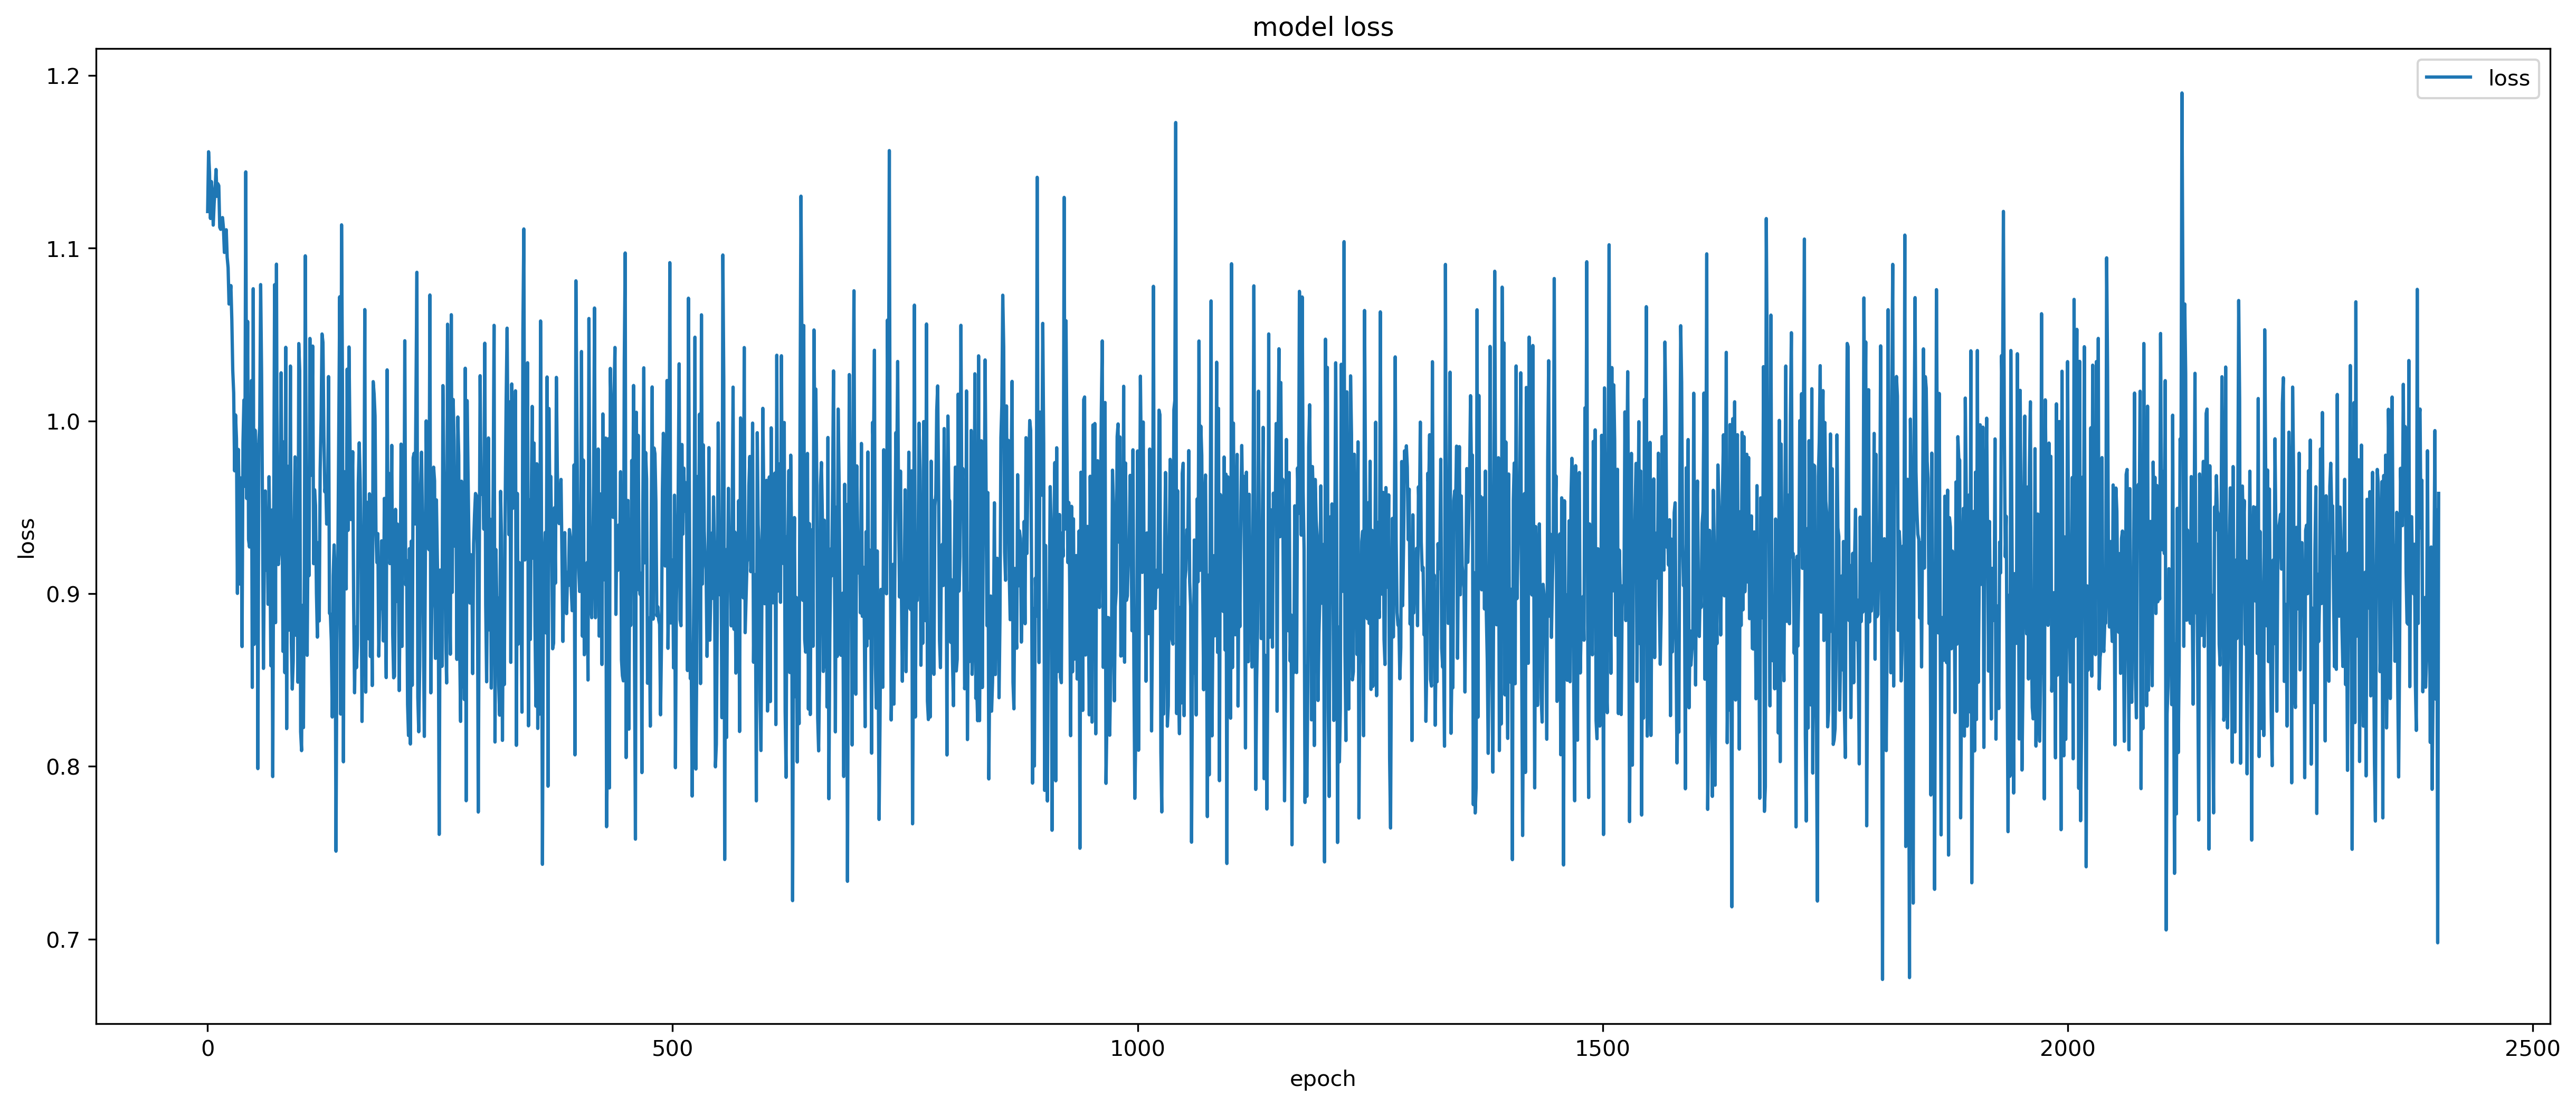

In [19]:
plt.figure(figsize=(20,8), dpi=300)
plt.plot(range(len(loss_list)), loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper right')
plt.show()

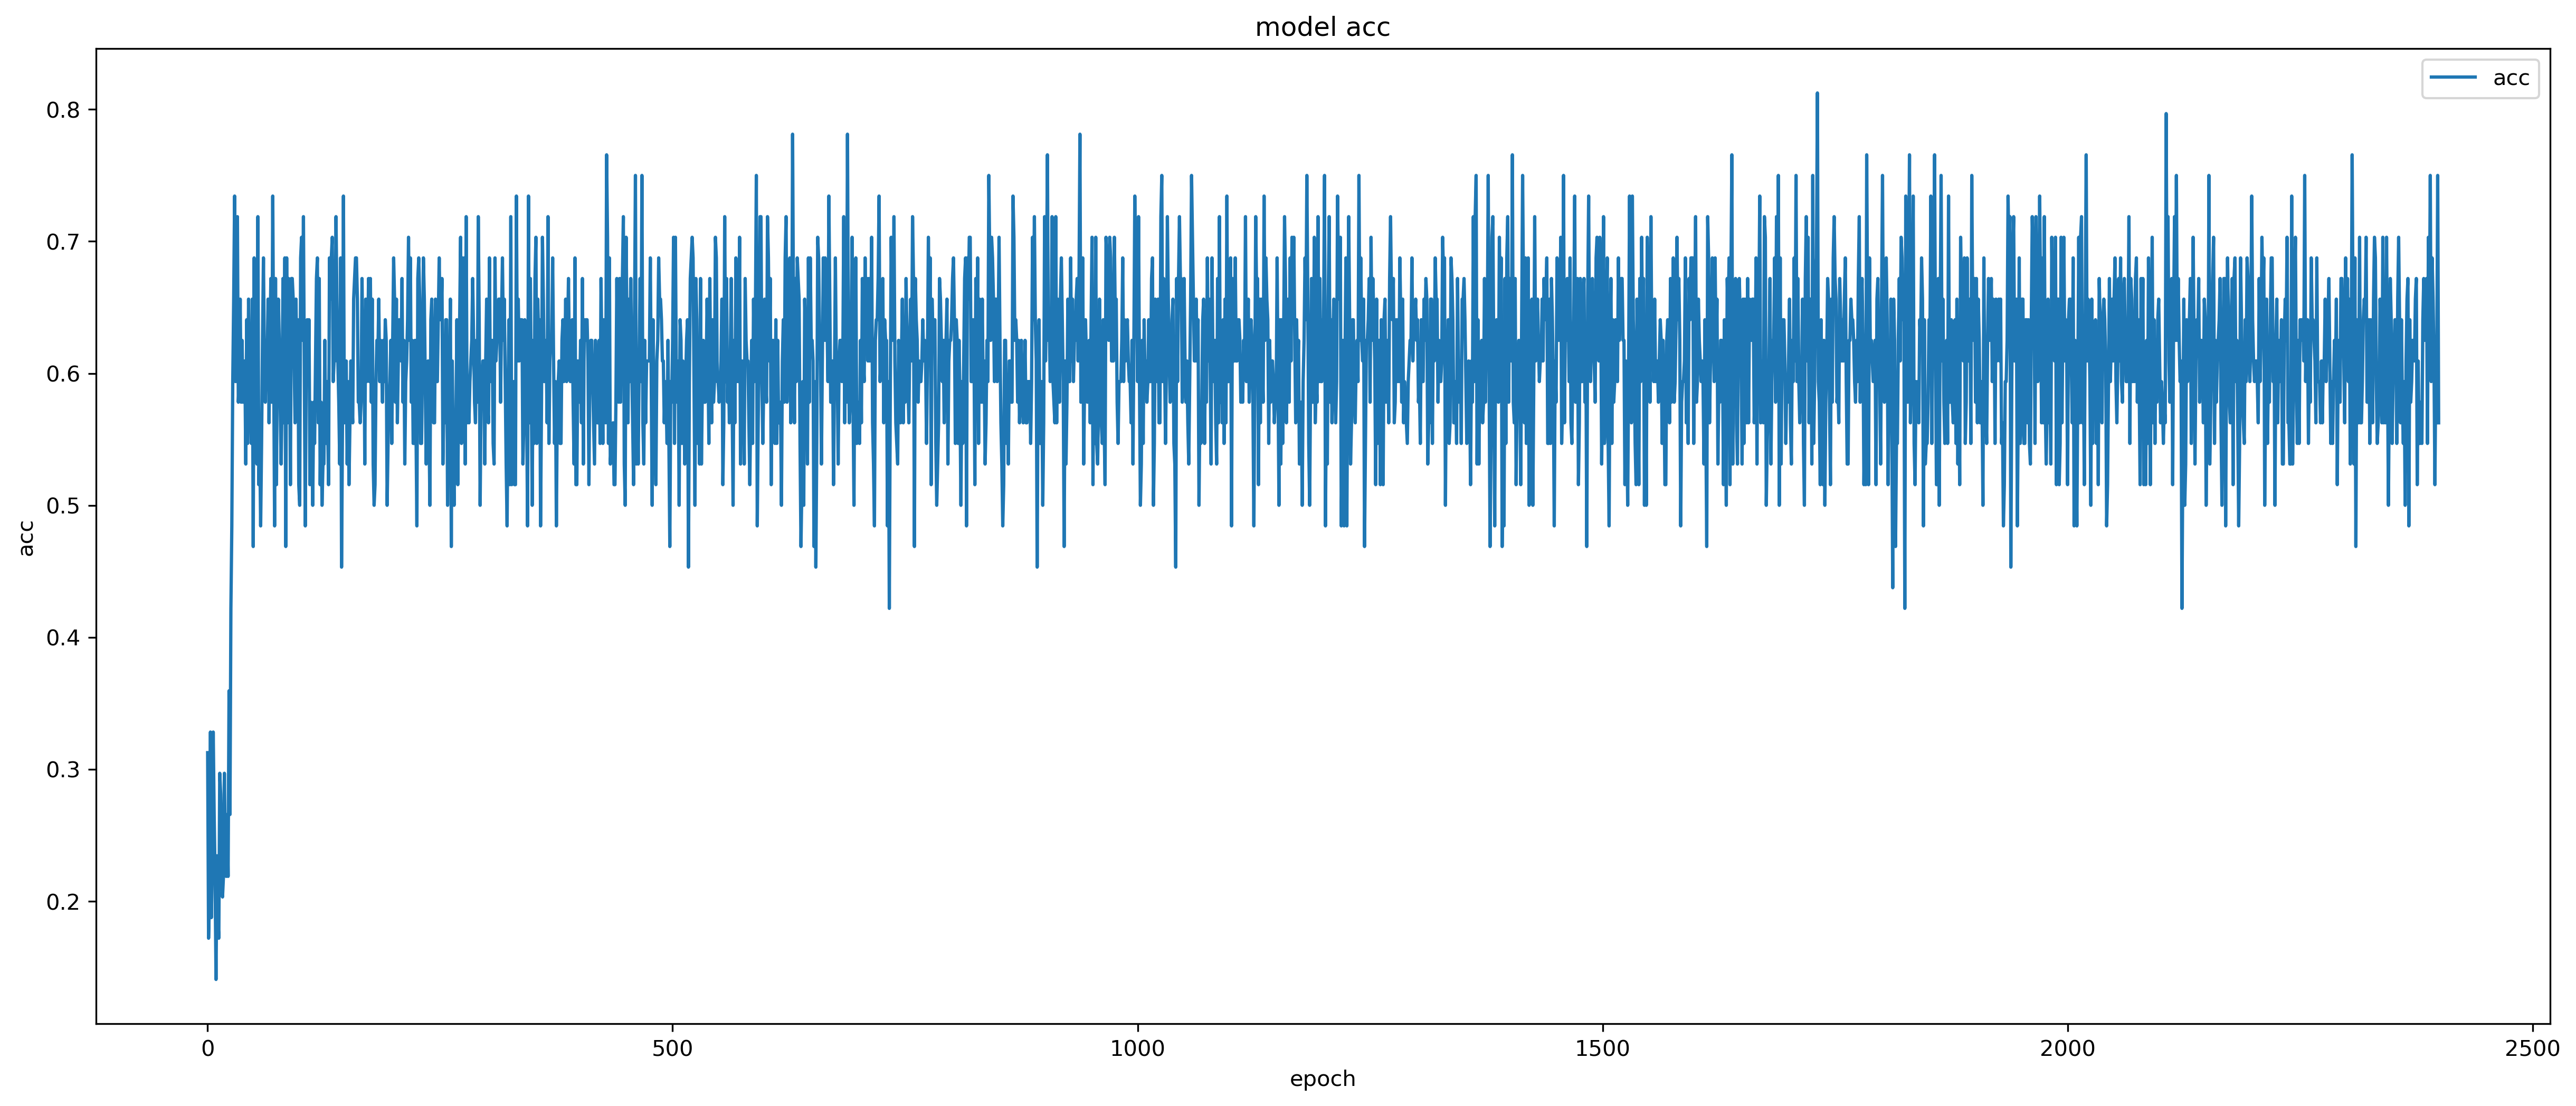

Best acc: 0.8125


In [20]:
plt.figure(figsize=(20,8), dpi=300)
plt.plot(range(len(acc_list)), acc_list)
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['acc'], loc='upper right')
plt.show()
print("Best acc:", max(acc_list))

In [21]:
actual_prices = test_data['Close'].values
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [22]:
x_test, y_test = [], []
for x in range(prediction_days, len(model_inputs)-window_size):
    x_test.append(model_inputs[x-prediction_days:x, :])
    # get label
    ratio = (model_inputs[x+window_size, :] - model_inputs[x, :]) / (model_inputs[x, :] + 0.00001)
    if ratio < cutoff.lower_bound:
        cla_label = 0.
    elif ratio > cutoff.upper_bound:
        cla_label = 2.
    else:
        cla_label = 1.
    y_test.append(cla_label)

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# test data
test_dataset = StockDataset(data=x_test, label=y_test.reshape((-1)))

# test loader
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        drop_last=True,
)


In [23]:
# inference

net.eval()
actual, pred = [], []

with torch.no_grad():
    for i, (test_inputs, test_labels) in enumerate(test_loader):
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        test_outputs = best_model(test_inputs)
        pred.extend(
            torch.max(test_outputs, dim=1)[1]
            .detach()
            .cpu()
            .numpy()
            .flatten()
            .tolist()
        )

        actual.extend(
            test_labels
            .detach()
            .cpu()
            .numpy()
            .flatten()
            .tolist()
        )

y_true, y_pred = np.array(actual), np.array(pred)


In [24]:
# calculate metrics

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

print(classification_report(y_true, y_pred))
print(accuracy_score(y_true, y_pred))
confusion_matrix(y_true, y_pred)

print(y_pred)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        92
         1.0       0.40      1.00      0.57       138
         2.0       0.00      0.00      0.00       116

    accuracy                           0.40       346
   macro avg       0.13      0.33      0.19       346
weighted avg       0.16      0.40      0.23       346

0.3988439306358382
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

